In [1]:
from sogym.env import sogym
from sogym.utils import FigureRecorderCallback
import numpy as np
import stable_baselines3
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize, SubprocVecEnv
from stable_baselines3 import PPO
%load_ext autoreload
%autoreload 2
print('SB3 vestsion:', stable_baselines3.__version__)

/Users/thomasrochefort/opt/anaconda3/envs/sb3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SB3 vestsion: 1.7.0


---
### Environment test and visualization:

In [2]:
from stable_baselines3.common.env_checker import check_env
# It will check your custom environment and output additional warnings if needed
check_env(sogym(nelx=100,nely=50,mode='train',observation_type='image'))

In [3]:
# Let's test the environment using the check_env util from SB3:
train_env = sogym(nelx=100,nely=50,mode='train',observation_type='dense')
eval_env = sogym(nelx=100,nely=50,mode='test',observation_type='dense')

In [4]:
# The training environment and the eval environment both have a different boundary conditions distribution:
print("Number of unique BC + desired volume frac combinations in the train distribution: ",len(train_env.BC_dict))
print("Number of unique BC + desired volume frac combinations in the test distribution: ",len(eval_env.BC_dict))

Number of unique BC + desired volume frac combinations in the train distribution:  4284
Number of unique BC + desired volume frac combinations in the test distribution:  2412


Volume:  0.49237241821927613
Reward  0.00163487176369609


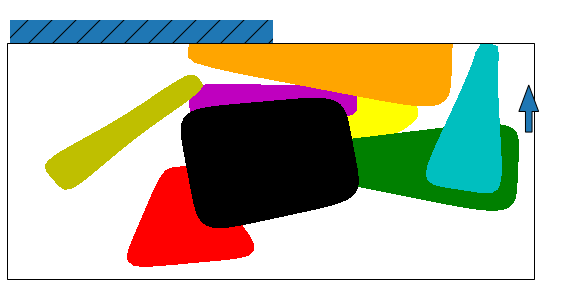

In [5]:
# Let's visualize the training environment on a random problem statement and visualize a 'successful' solution:
reward = 0.0
while reward<1e-3:
    obs = train_env.reset()
    done = False
    while not done:
        action = train_env.action_space.sample()
        obs, reward, done, info = train_env.step(action)
print("Volume: ", train_env.volume)
print("Reward ",reward)

train_env.plot()

Volume:  0.5356682490062138
Reward  0.0


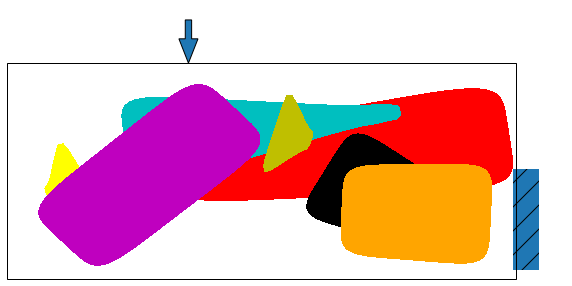

In [7]:
# Let's visualize the eval environment:
obs = eval_env.reset()
done = False
while not done:
    action = eval_env.action_space.sample()
    obs, reward, done, info = eval_env.step(action)
print("Volume: ", eval_env.volume)
print("Reward ",reward)
eval_env.plot()

---
### Multiprocessing

In [16]:
num_cpu = 8 # Number of processes to use
train_env = sogym(mode='train',observation_type='image')
env= make_vec_env(lambda:train_env, n_envs=num_cpu,vec_env_cls=SubprocVecEnv)
env=VecNormalize(env,gamma=1.0)

eval_env = sogym(mode='test',observation_type='image')
eval_env = make_vec_env(lambda:eval_env, n_envs=1,vec_env_cls=SubprocVecEnv)
eval_env =VecNormalize(eval_env,gamma=1.0)


In [18]:
# Let's  test that an eval callback actually works:
from stable_baselines3.common.callbacks import EvalCallback, CallbackList

eval_callback = EvalCallback(eval_env,log_path='tb_logs',eval_freq=100,deterministic=True,render=False)
callback = CallbackList([eval_callback,
                         FigureRecorderCallback(check_freq=8*32)])

--- 
### Defining the model

In [19]:
model = PPO("MultiInputPolicy",
            env,
            seed=42,
            n_steps=32,
            batch_size=32,
            verbose=0,
            gamma=1.0,
            tensorboard_log="tb_logs")

--- 
### Training

In [20]:
model.learn(4096*4,callback=callback,tb_log_name='PPO_test')
model.save('model_saved',)
env.save('env_saved.pkl')

Eval num_timesteps=800, episode_reward=0.00 +/- 0.00
Episode length: 8.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1600, episode_reward=0.00 +/- 0.00
Episode length: 8.00 +/- 0.00
Eval num_timesteps=2400, episode_reward=0.00 +/- 0.00
Episode length: 8.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3200, episode_reward=0.00 +/- 0.00
Episode length: 8.00 +/- 0.00
New best mean reward!
Eval num_timesteps=4000, episode_reward=0.00 +/- 0.00
Episode length: 8.00 +/- 0.00
Eval num_timesteps=4800, episode_reward=0.00 +/- 0.00
Episode length: 8.00 +/- 0.00
New best mean reward!


---
### Let's visualize the agent's performance:

In [11]:
env=sogym(mode='test',observation_type='dense')
env = make_vec_env(lambda:env, n_envs=1,vec_env_cls=SubprocVecEnv)
env = VecNormalize.load('env_saved.pkl',env)
env.training=False
env.norm_reward=False
model=model.load('model_saved')
#model.set_env(env)

[[-0.34376752  0.08250163  0.22266157  0.6264327  -0.49243253 -1.        ]]
[[-2.6293085 ]
 [-2.60151152]
 [-2.57379403]
 ...
 [-2.47111117]
 [-2.48035517]
 [-2.49770212]]
[-2.6293085  -2.60151152 -2.57379403 ... -2.47111117 -2.48035517
 -2.49770212]
--------
[[ 1.         -1.          0.21050337 -1.          0.39356667 -1.        ]]
[[-2.6293085  -3.06651742]
 [-2.60151152 -3.06651742]
 [-2.57379403 -3.06651743]
 ...
 [-2.47111117 -3.59252219]
 [-2.48035517 -3.68819005]
 [-2.49770212 -3.78385882]]
[-3.06651742 -3.06651742 -3.06651743 ... -3.59252219 -3.68819005
 -3.78385882]
--------
[[ 0.5421006  -0.6851253   0.4215751   0.18162724  0.11663434  0.3507802 ]]
[[-2.6293085  -3.06651742 -7.13055089]
 [-2.60151152 -3.06651742 -7.03769706]
 [-2.57379403 -3.06651743 -6.94630577]
 ...
 [-2.47111117 -3.59252219 -2.03645262]
 [-2.48035517 -3.68819005 -2.04897595]
 [-2.49770212 -3.78385882 -2.06331152]]
[-7.13055089 -7.03769706 -6.94630577 ... -2.03645262 -2.04897595
 -2.06331152]
--------
[[ 1

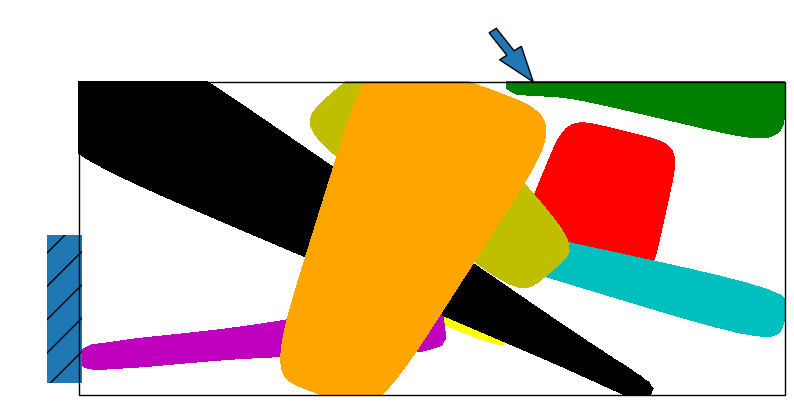

In [12]:
obs=env.reset()
dones=False

while dones== False:
    action, _states = model.predict(obs,deterministic=False)
    print(action)
    obs, rewards, dones, info = env.step(action)
    print(env.get_attr('Phi')[0])
    print(env.get_attr('Phi')[0][:,-1])
    print('--------')

#print("Reward:",rewards[0])
#print("Volume:",np.round(env.get_attr('volume')[0]*100,2),"%")
fig=env.env_method('plot')[0]
#fig = env.render()

fig

In [363]:
env.get_attr('Phi')[0].shape

(5151, 8)